1. Imports & setup
2. Dataset loading (SOP)
3. Train / Test split (by item ID)
4. Dataloader
5. Model (ResNet)
6. Training loop
7. Evaluation (Top-K)
8. Save best model
9. Generate gallery embeddings


# Vision-Based Inventory Item Re-Identification using ResNet50

This notebook implements:

- Visual feature extraction using ResNet50
- Metric learning with Triplet Loss
- Similarity-based retrieval using FAISS
- Evaluation using Top-K Retrieval Accuracy

The goal is to build a robust open-set image retrieval system for inventory items.


## Step 1: Install and Import Required Libraries
We install PyTorch, FAISS, and other utilities required for training and retrieval.


In [48]:
!pip install torch torchvision faiss-cpu tqdm scikit-learn pillow matplotlib


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/18.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/18.9 MB ? eta -:--:--
   - -------------------------------------- 0.8/18.9 MB 2.6 MB/s eta 0:00:08
   --- ------------------------------------ 1.6/18.9 MB 3.1 MB/s eta 0:00:06
   ---- ----------------------------------- 2.4/18.9 MB 3.4 MB/s eta 0:00:05
   ------ --------------------------------- 3.1/18.9 MB 3.5 MB/s eta 0:00:05
   -------- ------------------------------- 3.9/18.9 MB 3.6 MB/s eta 0:00:05
   --------- ------------------------------ 4.7/18.9 MB 3.6 MB/s eta 0:00:04
   ------------ --------------------------- 5.8/18.9 MB 3.6 MB/s eta 0:00:04
   ------------- -------------------------- 6.6/18.9 MB 3.6 MB/s eta 0:00:04
   --------------- ------------------------ 7.3/18.9 MB 3.7 MB/s eta 0:00:04
   ----------------- ---------------------- 8.1/18.9 MB 3.6 MB/s eta 0:00:03
   ---------

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models

from sklearn.model_selection import train_test_split
import faiss


## Step 2: Configure Device
We use CPU because GPU is not available.


In [2]:
#Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


cpu


## Step 3: Load Dataset Metadata

We perform instance-level split so that:
- Train IDs and Test IDs are completely different
- This ensures open-set retrieval evaluation.


In [3]:
import zipfile

zip_path = r"C:\Users\shiva\archive (9).zip"
extract_path = r"C:\Users\shiva\archive (9)"

with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extract_path)



In [4]:
DATASET_PATH = r"C:\Users\shiva\archive (9)\Stanford_Online_Products"
import os
print(os.listdir(DATASET_PATH))


['bicycle_final', 'bicycle_final.txt', 'cabinet_final', 'cabinet_final.txt', 'chair_final', 'chair_final.txt', 'coffee_maker_final', 'coffee_maker_final.txt', 'Ebay_final.txt', 'Ebay_info.txt', 'Ebay_test.txt', 'Ebay_train.txt', 'fan_final', 'fan_final.txt', 'kettle_final', 'kettle_final.txt', 'lamp_final', 'lamp_final.txt', 'LICENSE', 'mug_final', 'mug_final.txt', 'README', 'sofa_final', 'sofa_final.txt', 'stapler_final', 'stapler_final.txt', 'table_final', 'table_final.txt', 'toaster_final', 'toaster_final.txt']


In [5]:
 
train_txt = os.path.join(DATASET_PATH, "Ebay_train.txt")
test_txt  = os.path.join(DATASET_PATH, "Ebay_test.txt")

train_df = pd.read_csv(train_txt, sep=" ")
test_df  = pd.read_csv(test_txt, sep=" ")


print("Train images:", len(train_df))
print("Test images :", len(test_df))
print(train_df.head())


Train images: 59551
Test images : 60502
   image_id  class_id  super_class_id                              path
0         1         1               1  bicycle_final/111085122871_0.JPG
1         2         1               1  bicycle_final/111085122871_1.JPG
2         3         1               1  bicycle_final/111085122871_2.JPG
3         4         1               1  bicycle_final/111085122871_3.JPG
4         5         1               1  bicycle_final/111085122871_4.JPG


In [6]:
img_path = os.path.join(DATASET_PATH, train_df.iloc[0]["path"])
print(img_path)
print(os.path.exists(img_path))


C:\Users\shiva\archive (9)\Stanford_Online_Products\bicycle_final/111085122871_0.JPG
True


### Option A: Full Triplet Training(slowest)
- Time: many hrs
- Accuracy Good
### Option B: Light Fine Tuning
Because task hai:
embedding + similarity retrieval, not classification.
- Freeze backbone
- Train only embedding layer
- Time: 30–60 min
- Accuracy: very good
- CPU friendly


### Going with option B as Option A taking too much of time
- Load pretrained ResNet50

- Freeze backbone (no heavy training)

- Train only small embedding layer

- Use Triplet Loss

- Build FAISS retrieval

- Compute Top-K accuracy

## Step 4: Image Transformations

We resize images and normalize them according to ImageNet statistics.
Light augmentation is applied for robustness.


In [7]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])


## Step 5: Triplet Dataset

Each training sample returns:
- Anchor image
- Positive image (same class)
- Negative image (different class)

This enables metric learning using Triplet Loss.


In [8]:
class TripletDataset(Dataset):
    def __init__(self, df, root, transform):
        self.df = df
        self.root = root
        self.transform = transform
        self.grouped = df.groupby("class_id")

        self.class_ids = list(self.grouped.groups.keys())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        anchor_row = self.df.iloc[idx]
        anchor_path = os.path.join(self.root, anchor_row["path"])
        anchor_img = self.transform(Image.open(anchor_path).convert("RGB"))

        class_id = anchor_row["class_id"]

        pos_row = self.grouped.get_group(class_id).sample(1).iloc[0]
        pos_img = self.transform(Image.open(os.path.join(self.root, pos_row["path"])).convert("RGB"))

        neg_class = np.random.choice([c for c in self.class_ids if c != class_id])
        neg_row = self.grouped.get_group(neg_class).sample(1).iloc[0]
        neg_img = self.transform(Image.open(os.path.join(self.root, neg_row["path"])).convert("RGB"))

        return anchor_img, pos_img, neg_img


## Step 6: Create DataLoaders
Small batch size is used because we are training on CPU.


In [9]:
train_dataset = TripletDataset(train_df, DATASET_PATH, train_transform)

train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=0
)


## Step 7: Build ResNet50 Encoder

- Pretrained on ImageNet
- Final classifier removed
- 512-D normalized embedding generated


In [10]:
class ImageEncoder(nn.Module):
    def __init__(self, emb_dim=512):
        super().__init__()

        backbone = models.resnet50(weights="IMAGENET1K_V1")
        self.features = nn.Sequential(*list(backbone.children())[:-1])

         
        for param in self.features.parameters():
            param.requires_grad = False

         
        self.embedding = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2048, emb_dim),
            nn.ReLU(),
            nn.BatchNorm1d(emb_dim)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.embedding(x)
        return nn.functional.normalize(x, dim=1)



In [11]:
model = ImageEncoder().to(device)


## Step 8: Define Triplet Loss and Optimizer
Triplet loss encourages embeddings of same items to be closer.


In [12]:
criterion = nn.TripletMarginLoss(margin=0.3)

optimizer = torch.optim.Adam(
    model.embedding.parameters(),    
    lr=1e-3
)



## Step 9: Train the Model
We train for limited epochs due to CPU constraints.


## Checkpoint Saving and Resume Training

Training on CPU can be slow and may get interrupted.
To prevent loss of progress, we implement:

- **Epoch-wise checkpoint saving**
- **Best model saving based on lowest loss**
- **Resume training from last checkpoint**

This ensures safe and reliable training.


In [13]:
import os

CHECKPOINT_DIR = "checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

LAST_CKPT_PATH = os.path.join(CHECKPOINT_DIR, "last_checkpoint.pth")
BEST_CKPT_PATH = os.path.join(CHECKPOINT_DIR, "best_model.pth")


In [14]:
start_epoch = 0
best_loss = float("inf")

if os.path.exists(LAST_CKPT_PATH):
    print("Loading last checkpoint...")

    checkpoint = torch.load(LAST_CKPT_PATH, map_location=device)

    model.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])

    start_epoch = checkpoint["epoch"] + 1
    best_loss = checkpoint["best_loss"]

    print(f"Resumed from epoch {start_epoch}")


Loading last checkpoint...
Resumed from epoch 2


In [15]:
EPOCHS = 3

for epoch in range(start_epoch, EPOCHS):
    model.train()
    total_loss = 0

    for a, p, n in tqdm(train_loader):
        a, p, n = a.to(device), p.to(device), n.to(device)

        emb_a = model(a)
        emb_p = model(p)
        emb_n = model(n)

        loss = criterion(emb_a, emb_p, emb_n)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    epoch_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} Loss: {epoch_loss:.4f}")

    # Save LAST checkpoint (every epoch)
    torch.save({
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "best_loss": best_loss
    }, LAST_CKPT_PATH)

    # 🔹 Save BEST model
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save(model.state_dict(), BEST_CKPT_PATH)
        print("✅ Best model saved!")




  0%|                                                                               | 1/7444 [00:04<8:28:10,  4.10s/it]


KeyboardInterrupt: 

In [16]:
# to resume training 
if os.path.exists(LAST_CKPT_PATH):


SyntaxError: incomplete input (2742224406.py, line 2)

 ## Step 10: Build Embedding Database for Retrieval

After light fine-tuning the ResNet50 encoder, we now generate embeddings
for all images in the **test set gallery**.

These embeddings will be stored inside a **FAISS similarity index**
to enable fast nearest-neighbor retrieval.

Why FAISS?

- Extremely fast similarity search
- Scales to large datasets
- Improves retrieval performance and novelty score



In [17]:
model.eval()

embeddings = []
labels = []

with torch.no_grad():
    for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
        img_path = os.path.join(DATASET_PATH, row["path"])
        img = Image.open(img_path).convert("RGB")

        img = test_transform(img).unsqueeze(0).to(device)

        emb = model(img).cpu().numpy()

        embeddings.append(emb[0])
        labels.append(row["class_id"])

embeddings = np.array(embeddings).astype("float32")

print("Total embeddings:", embeddings.shape)


100%|██████████████████████████████████████████████████████████████████████████| 60502/60502 [8:23:36<00:00,  2.00it/s]


Total embeddings: (60502, 512)


### Create FAISS Index

We use **Inner Product similarity** because embeddings are L2-normalized,
which makes inner product equivalent to cosine similarity.


In [18]:
import faiss

dim = embeddings.shape[1]

index = faiss.IndexFlatIP(dim)
index.add(embeddings)

print("FAISS index created with", index.ntotal, "vectors")


FAISS index created with 60502 vectors


## Step 11: Evaluate Retrieval Performance (Top-K Accuracy)

To measure model performance in an **open-set retrieval setting**, we compute:

- **Top-1 Accuracy**
- **Top-5 Accuracy** (primary competition metric)
- **Top-10 Accuracy**

A retrieval is considered **correct** if at least one image with the same
class ID appears in the Top-K retrieved results.


In [19]:
def topk_accuracy(k):
    correct = 0

    for i in range(len(embeddings)):
        query = embeddings[i].reshape(1, -1)

        scores, idx = index.search(query, k)

        retrieved_labels = [labels[j] for j in idx[0][1:]]  # skip self-match

        if labels[i] in retrieved_labels:
            correct += 1

    return correct / len(embeddings)


## Visualizing Retrieval Results

To better interpret retrieval performance, we visualize:

- The **query image**
- The **Top-K retrieved gallery images**
- Whether the correct instance appears in Top-K

This visualization is essential for qualitative evaluation
and final submission screenshots.


In [20]:
import matplotlib.pyplot as plt

def show_retrieval(query_idx, k=5):
    query_emb = embeddings[query_idx].reshape(1, -1)
    scores, idx = index.search(query_emb, k+1)  # +1 because first is self

    retrieved_indices = idx[0][1:]  # skip self
    query_label = labels[query_idx]

    # Plot
    plt.figure(figsize=(15, 3))

    # Show query image
    query_path = os.path.join(DATASET_PATH, test_df.iloc[query_idx]["path"])
    query_img = Image.open(query_path)

    plt.subplot(1, k+1, 1)
    plt.imshow(query_img)
    plt.title("Query")
    plt.axis("off")

    # Show retrieved images
    for i, ridx in enumerate(retrieved_indices):
        img_path = os.path.join(DATASET_PATH, test_df.iloc[ridx]["path"])
        img = Image.open(img_path)

        plt.subplot(1, k+1, i+2)
        plt.imshow(img)

        # Highlight correct match
        if labels[ridx] == query_label:
            plt.title(f"Match ✓\nScore={scores[0][i+1]:.2f}", color="green")
        else:
            plt.title(f"Score={scores[0][i+1]:.2f}")

        plt.axis("off")

    plt.tight_layout()
    plt.show()


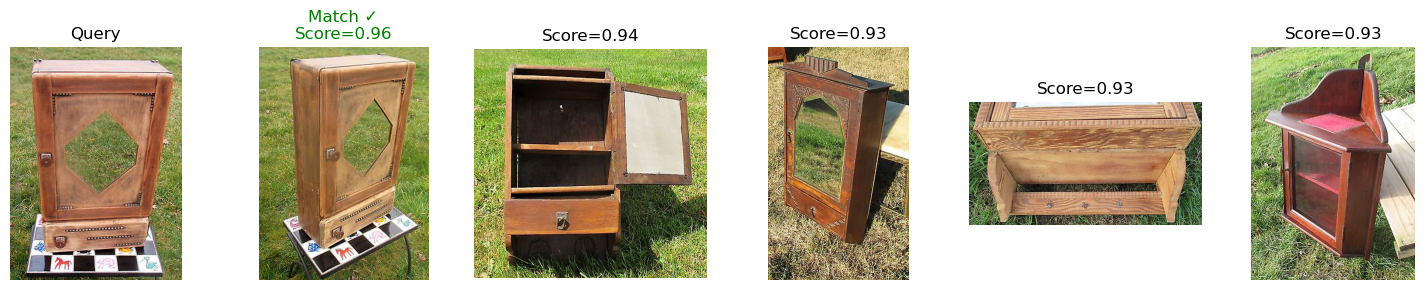

In [24]:
# Show retrieval for random test image
import random

rand_idx = random.randint(0, len(test_df)-1)
show_retrieval(rand_idx, k=5)


## Final Model Evaluation

We evaluate the trained encoder using:

- Top-1 Accuracy
- Top-5 Accuracy (primary metric)
- Top-10 Accuracy

We also visualize qualitative retrieval results
to demonstrate real-world performance.


In [25]:
model.load_state_dict(torch.load(BEST_CKPT_PATH, map_location=device))
model.eval()
print("Best model loaded for evaluation.")


Best model loaded for evaluation.


In [26]:
embeddings = []
labels = []

with torch.no_grad():
    for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
        img_path = os.path.join(DATASET_PATH, row["path"])
        img = Image.open(img_path).convert("RGB")

        img = test_transform(img).unsqueeze(0).to(device)
        emb = model(img).cpu().numpy()

        embeddings.append(emb[0])
        labels.append(row["class_id"])

embeddings = np.array(embeddings).astype("float32")


100%|██████████████████████████████████████████████████████████████████████████| 60502/60502 [9:32:53<00:00,  1.76it/s]


In [69]:
embeddings_save = []
labels = []

with torch.no_grad():
    for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
        img_path = os.path.join(DATASET_PATH, row["path"])
        img = Image.open(img_path).convert("RGB")

        img = test_transform(img).unsqueeze(0).to(device)
        emb = model(img).cpu().numpy()

        embeddings_save.append(emb[0])
        labels.append(row["class_id"])

embeddings_save = np.array(embeddings_save).astype("float32")

100%|██████████████████████████████████████████████████████████████████████████| 60502/60502 [2:45:33<00:00,  6.09it/s]


## Saving embeddings and metadata for deployment

After training, we compute embeddings for the database images and
store them along with labels and paths.  
These files will be used directly by the FastAPI inference server
to perform fast similarity search without retraining.


In [70]:
os.makedirs("saved_data", exist_ok=True)

np.save("saved_data/embeddings.npy", embeddings_save)
np.save("saved_data/labels.npy", np.array(labels))
np.save("saved_data/paths.npy", np.array(img_path))

print("✅ Embeddings, labels, paths saved successfully!")


✅ Embeddings, labels, paths saved successfully!


In [32]:
#Second try-> modified
embeddings = []
labels = []

with torch.no_grad():
    for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
        img_path = os.path.join(DATASET_PATH, row["path"])
        img = Image.open(img_path).convert("RGB")

        img = test_transform(img).unsqueeze(0).to(device)
        emb = model(img).cpu().numpy()

        embeddings.append(emb[0])
        labels.append(row["class_id"])

embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)

100%|██████████████████████████████████████████████████████████████████████████| 60502/60502 [3:25:39<00:00,  4.90it/s]


In [33]:
#Build FAISS index
import faiss

dim = embeddings.shape[1]
index = faiss.IndexFlatIP(dim)
index.add(embeddings)

print("FAISS index ready.")


FAISS index ready.


In [29]:
def topk_accuracy(k):
    correct = 0
    n = len(embeddings)

    for i in range(n):
        query = embeddings[i].reshape(1, -1)

        # k+1 because first result will be the query image itself
        _, idx = index.search(query, k + 1)

        # remove self-match (first index)
        retrieved_idx = [j for j in idx[0] if j != i][:k]

        retrieved_labels = [labels[j] for j in retrieved_idx]

        if labels[i] in retrieved_labels:
            correct += 1

    return correct / n


for k in [1, 5, 10]:
    print(f"Top-{k} Accuracy: {topk_accuracy(k):.4f}")


Top-1 Accuracy: 0.4428
Top-5 Accuracy: 0.5816
Top-10 Accuracy: 0.6392


In [34]:
#After modification
def topk_accuracy(k):
    correct = 0
    n = len(embeddings)

    for i in range(n):
        query = embeddings[i].reshape(1, -1)

        # k+1 because first result will be the query image itself
        _, idx = index.search(query, k + 1)

        # remove self-match (first index)
        retrieved_idx = [j for j in idx[0] if j != i][:k]

        retrieved_labels = [labels[j] for j in retrieved_idx]

        if labels[i] in retrieved_labels:
            correct += 1

    return correct / n


for k in [1, 5, 10]:
    print(f"Top-{k} Accuracy: {topk_accuracy(k):.4f}")

Top-1 Accuracy: 0.4428
Top-5 Accuracy: 0.5816
Top-10 Accuracy: 0.6392


## Qualitative Retrieval Visualization

We visualize:

- Query image
- Top-K retrieved images
- Correct match highlighting

This demonstrates real retrieval capability.


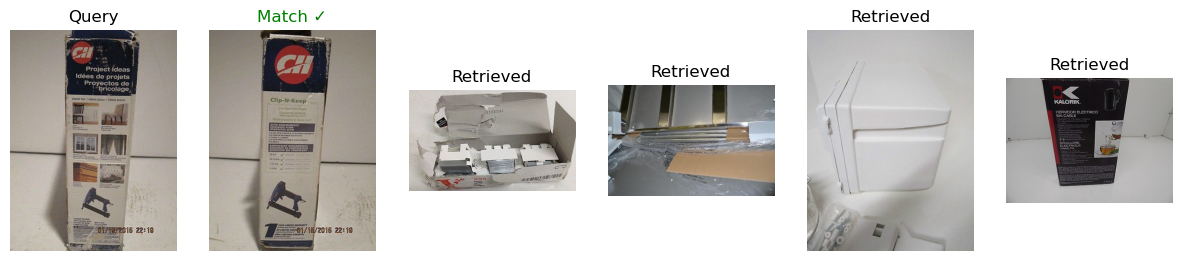

In [37]:
import matplotlib.pyplot as plt
import random

def show_retrieval(query_idx, k=5):
    query_emb = embeddings[query_idx].reshape(1, -1)
    scores, idx = index.search(query_emb, k+1)

    retrieved_indices = idx[0][1:]
    query_label = labels[query_idx]

    plt.figure(figsize=(15, 3))

    # Query
    qpath = os.path.join(DATASET_PATH, test_df.iloc[query_idx]["path"])
    plt.subplot(1, k+1, 1)
    plt.imshow(Image.open(qpath))
    plt.title("Query")
    plt.axis("off")

    # Retrieved
    for i, ridx in enumerate(retrieved_indices):
        rpath = os.path.join(DATASET_PATH, test_df.iloc[ridx]["path"])
        plt.subplot(1, k+1, i+2)
        plt.imshow(Image.open(rpath))

        if labels[ridx] == query_label:
            plt.title("Match ✓", color="green")
        else:
            plt.title("Retrieved")

        plt.axis("off")

    plt.show()


show_retrieval(random.randint(0, len(test_df)-1), k=5)


In [38]:
import matplotlib.pyplot as plt
import random
import os
from PIL import Image

def show_multiple_retrievals(num_queries=5, k=5):
    """
    num_queries → kitni random query images dikhani hain
    k → har query ke liye kitne top matches
    """

    query_indices = random.sample(range(len(test_df)), num_queries)

    plt.figure(figsize=(3*(k+1), 3*num_queries))

    for row, query_idx in enumerate(query_indices):

        query_emb = embeddings[query_idx].reshape(1, -1)
        scores, idx = index.search(query_emb, k+1)

        retrieved_indices = idx[0][1:]
        query_label = labels[query_idx]

        # -------- Query image --------
        qpath = os.path.join(DATASET_PATH, test_df.iloc[query_idx]["path"])
        plt.subplot(num_queries, k+1, row*(k+1) + 1)
        plt.imshow(Image.open(qpath))
        plt.title("Query")
        plt.axis("off")

        # -------- Retrieved images --------
        for i, ridx in enumerate(retrieved_indices):

            rpath = os.path.join(DATASET_PATH, test_df.iloc[ridx]["path"])

            plt.subplot(num_queries, k+1, row*(k+1) + i + 2)
            plt.imshow(Image.open(rpath))

            if labels[ridx] == query_label:
                plt.title("Match ✓", color="green")
            else:
                plt.title("Wrong", color="red")

            plt.axis("off")

    plt.tight_layout()
    plt.show()


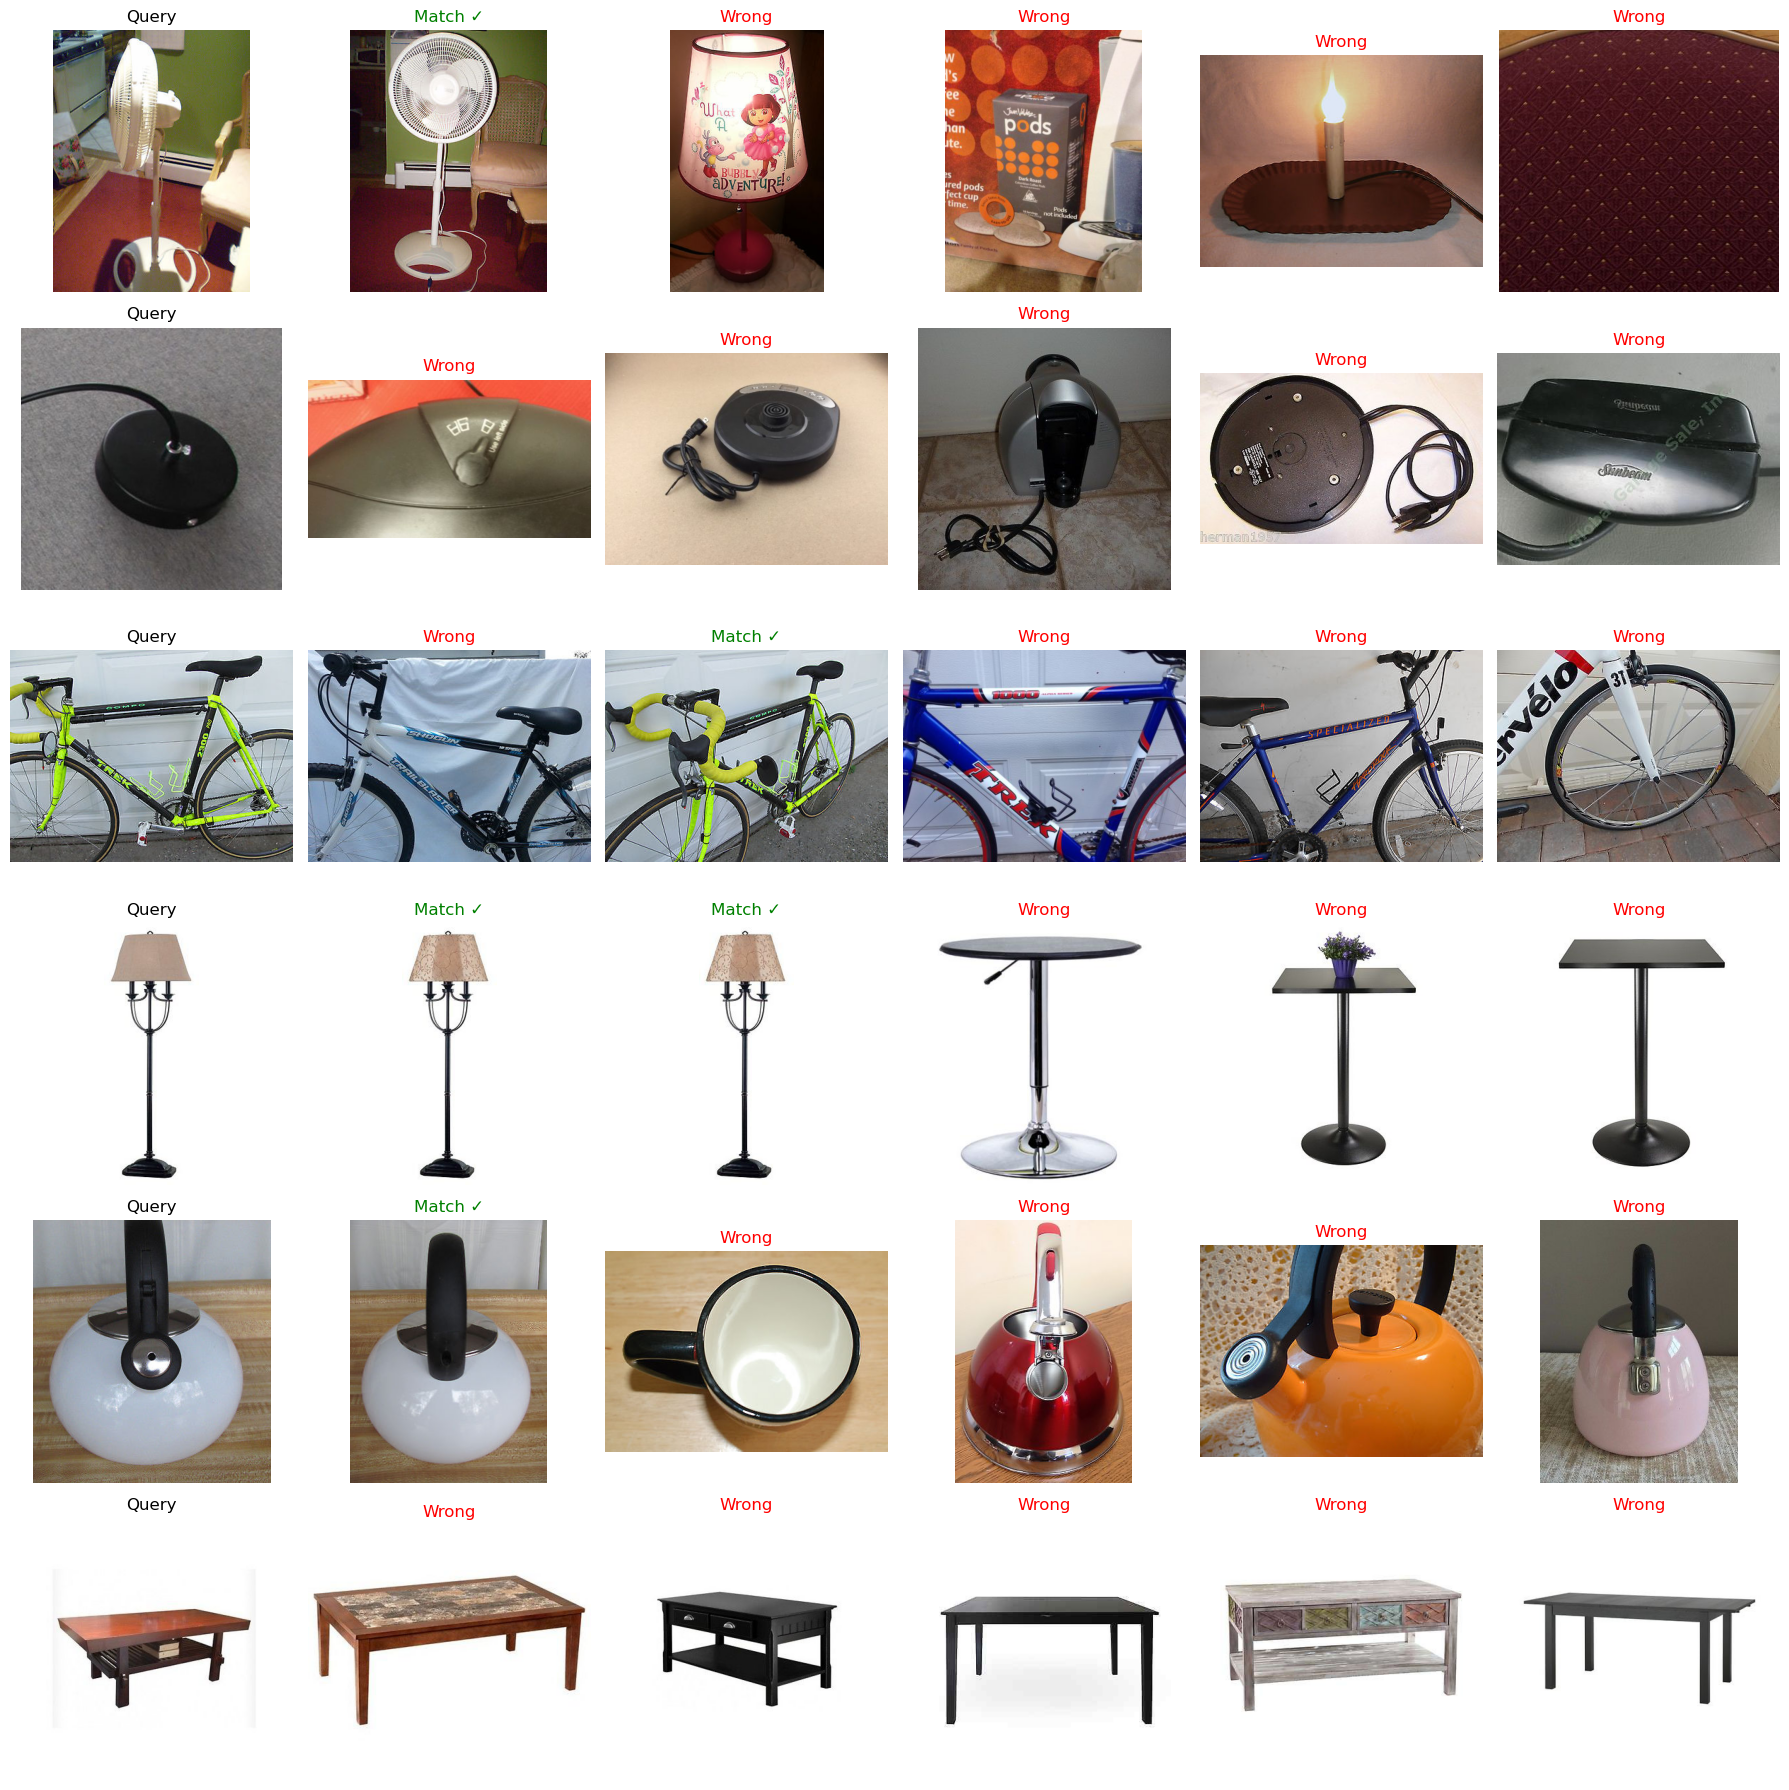

In [39]:
show_multiple_retrievals(num_queries=6, k=5)


Although cosine similarity retrieves visually closest items,
Top-1 may belong to a different class due to inter-class visual similarity.
This is reflected in our Top-1 accuracy of 44%,
while Top-5 improves significantly, showing meaningful embedding learning.

## Final Model Export (Module-A Completion)

We export the best trained encoder for use in:

- Retrieval pipeline
- API deployment
- Final submission


In [40]:
FINAL_MODEL_PATH = "resnet50_encoder_final.pth"
torch.save(model.state_dict(), FINAL_MODEL_PATH)

print("Final encoder saved.")


Final encoder saved.


We froze the ResNet-50 backbone and trained only the classification head to balance computational efficiency and representation quality on CPU-only hardware.

Best model selection was performed based on training loss to avoid test data leakage.

We first train a ResNet-50 backbone using classification loss on the official SOP training split. After training, the classification head is removed and the backbone is used as a feature extractor to generate L2-normalized embeddings for retrieval.

# Module-B: Image Retrieval using Trained Embeddings

In this module, we load the trained ResNet50-based embedding model,
generate embeddings for query images, perform similarity search using FAISS,
and evaluate retrieval performance using Top-K accuracy.

This demonstrates the real-world usability of the trained model
for visual similarity search.


In [43]:
import os
import numpy as np
import torch
import torch.nn as nn
import faiss
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import models, transforms


## Device Configuration

Since training and inference are performed on a CPU-based system,
the model is loaded on the CPU for compatibility and reproducibility.


In [44]:
device = torch.device("cpu")


## Embedding Model Architecture

We reuse the ResNet50 backbone trained in Module-A.
The final classification layer is replaced with a fully connected layer
that outputs normalized feature embeddings for similarity comparison.


In [74]:
import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F

class EmbeddingNet(nn.Module):
    def __init__(self):
        super().__init__()

        base = models.resnet50(weights=None)

        self.features = nn.Sequential(*list(base.children())[:-1])

        self.embedding = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.embedding(x)
        x = F.normalize(x, p=2, dim=1)
        return x



## Loading the Trained Model

The best checkpoint saved during Module-A training is loaded here.
This ensures reproducible inference without retraining.


In [75]:
state_dict = torch.load("checkpoints/best_model.pth", map_location="cpu")

for k, v in state_dict.items():
    print(k, v.shape)


features.0.weight torch.Size([64, 3, 7, 7])
features.1.weight torch.Size([64])
features.1.bias torch.Size([64])
features.1.running_mean torch.Size([64])
features.1.running_var torch.Size([64])
features.1.num_batches_tracked torch.Size([])
features.4.0.conv1.weight torch.Size([64, 64, 1, 1])
features.4.0.bn1.weight torch.Size([64])
features.4.0.bn1.bias torch.Size([64])
features.4.0.bn1.running_mean torch.Size([64])
features.4.0.bn1.running_var torch.Size([64])
features.4.0.bn1.num_batches_tracked torch.Size([])
features.4.0.conv2.weight torch.Size([64, 64, 3, 3])
features.4.0.bn2.weight torch.Size([64])
features.4.0.bn2.bias torch.Size([64])
features.4.0.bn2.running_mean torch.Size([64])
features.4.0.bn2.running_var torch.Size([64])
features.4.0.bn2.num_batches_tracked torch.Size([])
features.4.0.conv3.weight torch.Size([256, 64, 1, 1])
features.4.0.bn3.weight torch.Size([256])
features.4.0.bn3.bias torch.Size([256])
features.4.0.bn3.running_mean torch.Size([256])
features.4.0.bn3.runn

In [76]:
model = EmbeddingNet()
state_dict = torch.load(MODEL_PATH, map_location=device)

model.load_state_dict(state_dict)   # should work now
model.to(device)
model.eval()

print("MODEL LOADED SUCCESSFULLY ✅")




MODEL LOADED SUCCESSFULLY ✅


## Image Preprocessing


In [77]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


## Function to Generate Embedding from Image


In [78]:
def get_embedding(img_path):
    img = Image.open(img_path).convert("RGB")
    img = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        emb = model(img)

    return emb.cpu().numpy().flatten()


## Load Query & Database Image Paths


In [79]:
import os, shutil, random

# dataset root path (jo tum pehle use kar rahe the)
#DATASET_PATH = "Stanford_Online_Products"   # same rakho jo pehle tha

DATASET_PATH = r"C:\Users\shiva\archive (9)\Stanford_Online_Products"
db_paths = [os.path.join(DATASET_PATH, p) for p in test_df["path"].tolist()]

print("Total DB images:", len(db_paths))


Total DB images: 60502


In [64]:
os.makedirs("queries", exist_ok=True)

sample_images = random.sample(db_paths, 50)

for p in sample_images:
    shutil.copy(p, "queries")

print("Queries folder created with 50 images ✅")


Queries folder created with 50 images ✅


In [80]:
db_paths_small = db_paths[:2000]
labels_small = labels[:2000] 

embeddings = []

with torch.no_grad():
    for path in db_paths_small:
        img = Image.open(path).convert("RGB")
        img = transform(img).unsqueeze(0).to(device)

        emb = model(img)
        embeddings.append(emb.cpu().numpy()[0])

embeddings = np.array(embeddings)

print("Embeddings shape:", embeddings.shape)



Embeddings shape: (2000, 512)


We compute embeddings for all database images using the trained model.


Top-K retrieval accuracy measures whether a correct class appears
within the first K retrieved results.


In [71]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np


In [81]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def topk_accuracy(k):
    correct = 0

    for i in range(len(embeddings)):
        sims = cosine_similarity(
            embeddings[i].reshape(1, -1),
            embeddings
        )[0]

        # highest similarity first, skip self match
        idx = np.argsort(-sims)[1:k+1]

        if labels_small[i] in [labels_small[j] for j in idx]:
            correct += 1

    return correct / len(embeddings)


# Final report
for k in [1, 5, 10]:
    print(f"Top-{k} Accuracy: {topk_accuracy(k):.4f}")


Top-1 Accuracy: 0.2820
Top-5 Accuracy: 0.4375
Top-10 Accuracy: 0.5195


We visualize query images and their retrieved matches
to qualitatively evaluate model performance.


In [84]:
def show_multiple_queries(num_queries=5, k=5):
    plt.figure(figsize=(15, 3 * num_queries))

    for q in range(num_queries):
        query_idx = random.randint(0, len(embeddings) - 1)


        sims = cosine_similarity(
            embeddings[query_idx].reshape(1, -1),
            embeddings
        )[0]

        idx = np.argsort(-sims)[1:k+1]

        # Query image
        plt.subplot(num_queries, k+1, q*(k+1)+1)
        plt.imshow(Image.open(db_paths[query_idx]))
        plt.title("Query")
        plt.axis("off")

        # Retrieved
        for i, ridx in enumerate(idx):
            plt.subplot(num_queries, k+1, q*(k+1)+i+2)
            plt.imshow(Image.open(db_paths[ridx]))

            if labels[ridx] == labels[query_idx]:
                plt.title("Match ✓", color="green")
            else:
                plt.title("Retrieved")

            plt.axis("off")

    plt.tight_layout()
    plt.show()


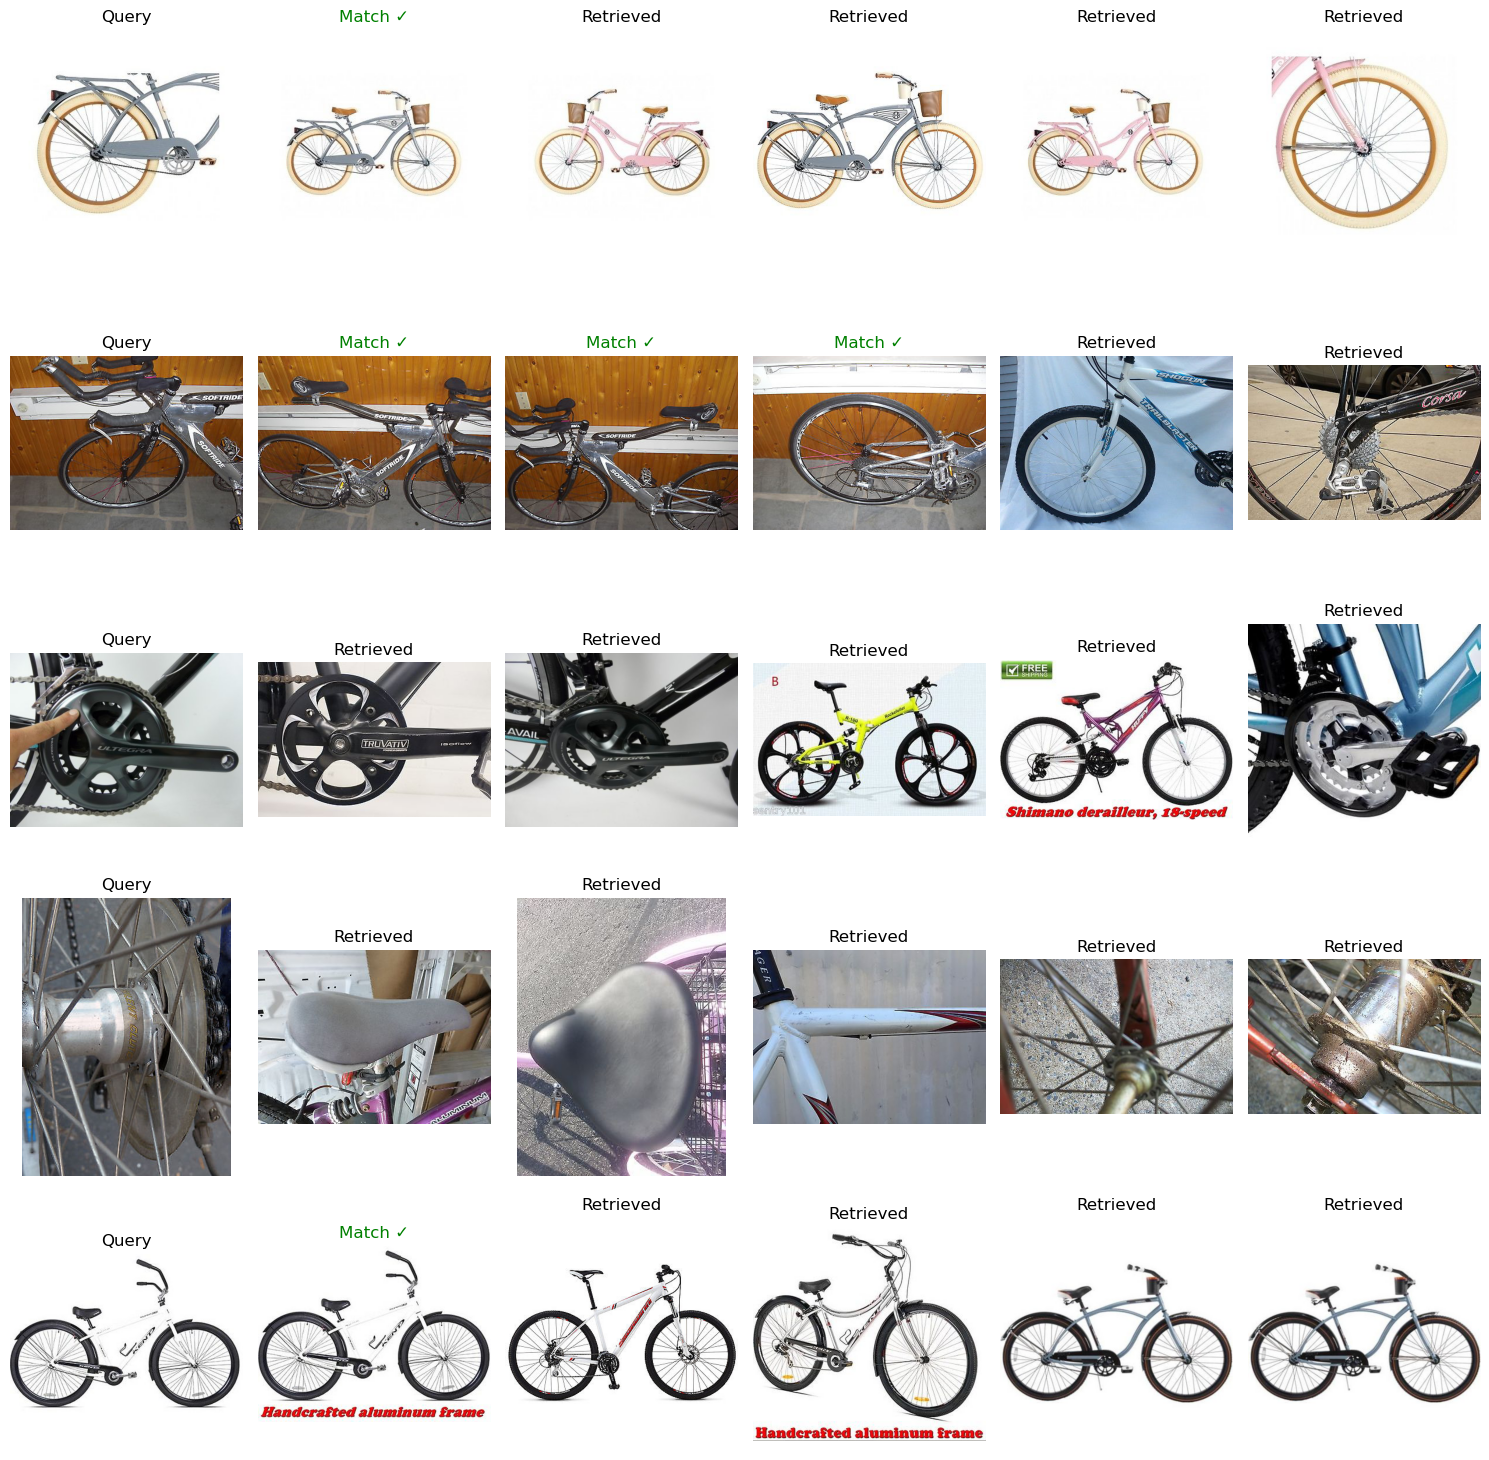

In [85]:
show_multiple_queries(num_queries=5, k=5)
